In [28]:
import os
import datetime
import copy
import torch
from torch.nn import Module
import tqdm
import numpy as np 
import gym
from gym import Env
from gym.spaces import Box
from gym .utils.env_checker import check_env
from typing import (
    OrderedDict,
    List,
    Tuple,
    Callable,
)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import stable_baselines3
from stable_baselines3 import A2C
from stable_baselines3.common.env_checker import check_env

In [29]:
print(stable_baselines3.__version__)
print(gym.__version__) # should be 0.21.0 to be compatible with stable_baselines3 1.8

1.8.0
0.21.0



#### mvp
- See if there is transfer from learning regression models from a couple different sine curves to yet a different sine curve.
- We know there is transfer is (1) it takes less to train and (2) if the model chooses to reuse layers rather than create new ones.
- We first train regression models without the meta-learner (because the 'meta' ability cannot do anything without pre-trained weights).
- The meta-learner will then output actions to build a model for unseen data.
- Actions will be continuous, a vector of probabilities corresponding to which layer to add from the layer pool. One of these probabilities corresponds to adding no layer and just training the architecture as it is.

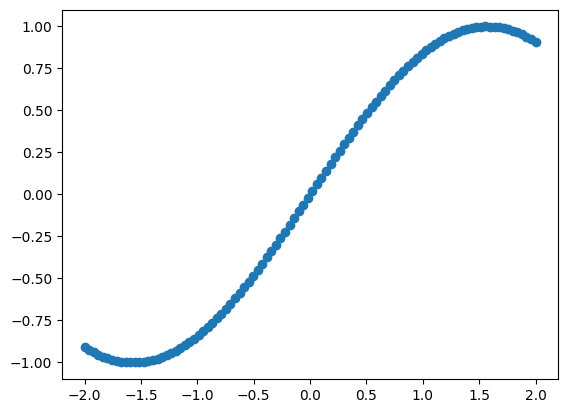

In [175]:
plt.plot(np.linspace(-2, 2, 100), np.sin(np.linspace(-2, 2, 100)), marker='o');

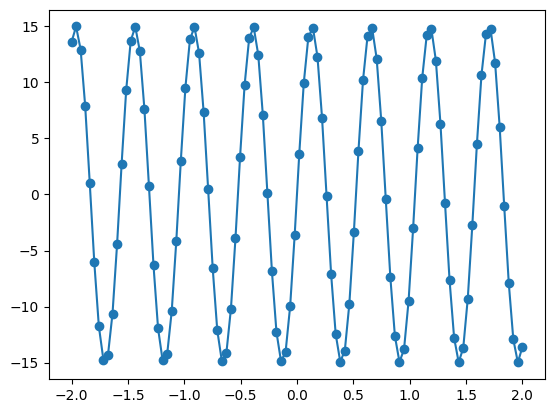

In [45]:
plt.plot(np.linspace(-2, 2, 100), 15*np.sin([12*x for x in np.linspace(-2, 2, 100)]), marker='o');
# increasing amplitude by 3 and frequency by 4

In [30]:
N = 100 # number of datapoints 
xvalues = np.linspace(-2, 2, N) 

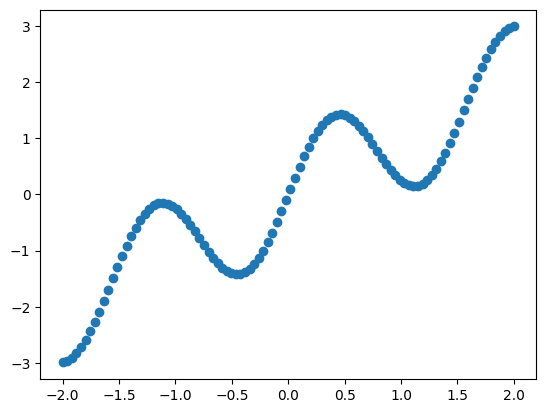

In [31]:
sine_wave = xvalues + np.sin(4*xvalues)
plt.plot(xvalues, sine_wave, 'o');

In [32]:
# y
sine_wave

array([-2.98935825, -2.95947432, -2.90353058, -2.82193204, -2.71575235,
       -2.58670583, -2.43710276, -2.26978919, -2.08807276, -1.89563649,
       -1.69644281, -1.49463023, -1.29440554, -1.09993415, -0.91523152,
       -0.74405849, -0.58982329, -0.4554927 , -0.34351473, -0.25575481,
       -0.19344717, -0.15716269, -0.14679399, -0.16155828, -0.20001769,
       -0.2601168 , -0.33923622, -0.4342608 , -0.54166086, -0.6575842 ,
       -0.77795645, -0.89858731, -1.01527972, -1.12393929, -1.22068097,
       -1.30193034, -1.36451675, -1.40575595, -1.42352009, -1.41629312,
       -1.38321035, -1.32408098, -1.23939303, -1.13030068, -0.99859414,
       -0.84665305, -0.67738437, -0.49414671, -0.30066274, -0.10092218,
        0.10092218,  0.30066274,  0.49414671,  0.67738437,  0.84665305,
        0.99859414,  1.13030068,  1.23939303,  1.32408098,  1.38321035,
        1.41629312,  1.42352009,  1.40575595,  1.36451675,  1.30193034,
        1.22068097,  1.12393929,  1.01527972,  0.89858731,  0.77

In [33]:
def build_model():
    return torch.nn.Sequential(
        torch.nn.Linear(1, 24),
        torch.nn.ReLU(),
        torch.nn.Linear(24, 24), # hidden layer 1
        torch.nn.ReLU(),
        torch.nn.Linear(24, 24), # hidden layer 2
        torch.nn.ReLU(),
        torch.nn.Linear(24, 1)
    )

def save_model(model: torch.nn.Module,path: str) -> None:
    torch.save(model.state_dict(), path)

def load_model(model: torch.nn.Module, path: str) -> torch.nn.Module:
    model.load_state_dict(torch.load(path))    
    
def split_data(X: np.ndarray,
               y: np.ndarray) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    # wraps sklearn's train_test_split
    # added functionality is converting to torch tensor type and reshaping
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
    return X_train, y_train, X_test, y_test

def train_regression_model(model: torch.nn.Module,
                           opt: torch.optim,
                           X_train: torch.Tensor, 
                           y_train: torch.Tensor, 
                           X_test: torch.Tensor, 
                           y_test: torch.Tensor, 
                           n_epochs: int=500, 
                           batch_size: int=1,
                           show_progress: bool=True) -> Tuple[List[torch.Tensor], 
                                                              List[torch.Tensor], 
                                                              float, 
                                                              OrderedDict[str, torch.tensor]]:
    loss_fn = torch.nn.MSELoss()
    best_mse = np.inf
    best_weights = None
    loss_history = []
    prediction_history = []
    
    ##############
    # 500 epochs 
    ##############
    for epoch in range(n_epochs):
        # train model on batches (which here is just a singular value)
        model.train()
        ################
        # 100 samples 
        ################
        if show_progress:
            pbar = tqdm.tqdm(total=len(X_train))
            pbar.set_description(f"Epoch {epoch}")
        for batch_index in range(round(len(X_train)/batch_size)):
            ################
            # 1 sample at a time (batch size = 1)
            ################
            X_batch = X_train[batch_index : batch_index + batch_size]
            y_batch = y_train[batch_index : batch_index + batch_size]

            # forward pass
            y_pred = model(X_batch)
            
            loss = loss_fn(y_pred, y_batch)

            # update weights via backprop
            opt.zero_grad()
            loss.backward()
            opt.step()

            if show_progress: pbar.update(10)
        if show_progress: pbar.close()

        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_test)
        mse = loss_fn(y_pred, y_test)
        mse = float(mse)
        loss_history.append(mse)
        prediction_history.append(y_pred)
        if mse < best_mse:
            best_mse = mse
            best_weights = copy.deepcopy(model.state_dict())
    
    return prediction_history, loss_history, best_mse, best_weights

def predict_from_composed_layers(layers):
    y_hats = []
    for x in np.linspace(-2,2,100):
        x = torch.Tensor([x])
        for i in range(len(layers)-1):
            x = torch.nn.functional.relu(layers[i](x))
        x = layers[-1](x) # do not relu the very last calculation
        y_hats.append(x)
    return y_hats

def make_predictions(X: torch.Tensor, model: torch.nn.Module) -> List[torch.Tensor]:
    # function to get yhat from target network
    return [model(torch.tensor(sample).float()) 
            for sample in X.reshape((N,1))]

def plot_predictions_versus_ground(X: torch.Tensor, 
                                   y: torch.Tensor, 
                                   y_hat: torch.Tensor,
                                   plot_title: str="line fit") -> None:

    # function to plot predicted curve versus actual curve
    # assumes x and y are both numpy arrays
    # assumes y_hat is generated by make_predictions()
    plt.plot(X, y)
    plt.plot(X, np.array([_.detach().numpy() for _ in y_hat]));
    plt.title(plot_title)


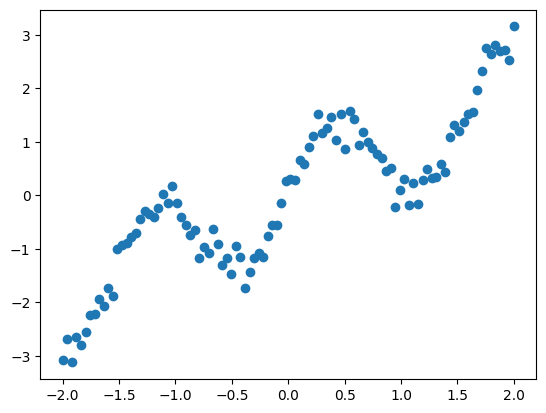

In [34]:
noisy_sine_wave = xvalues + np.sin(4*xvalues) + np.random.normal(0,0.2, 100)
plt.plot(xvalues, noisy_sine_wave, 'o');

In [35]:
x_for_split = xvalues.reshape((N,1))
X_train, y_train, X_test, y_test = split_data(x_for_split, sine_wave)
noisy_X_train, noisy_y_train, noisy_X_test, noisy_y_test = split_data(x_for_split, noisy_sine_wave)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


torch.Size([70, 1])
torch.Size([70, 1])
torch.Size([30, 1])
torch.Size([30, 1])


In [36]:
x_for_split.shape

(100, 1)

In [37]:
sine_wave.shape

(100,)

In [38]:
# depiction of how batch training works (i.e., that you just returned a 
# vector with as the same # of outputs and you passed inputs)
model = build_model()
print(X_train[0:5])
print(model(X_train[0:5]))
print()
print(X_train[0])
print(model(X_train[0]))

tensor([[ 1.7576],
        [-0.4242],
        [ 0.5455],
        [ 0.2222],
        [-1.7980]])
tensor([[0.1054],
        [0.2098],
        [0.1739],
        [0.1950],
        [0.1540]], grad_fn=<AddmmBackward0>)

tensor([1.7576])
tensor([0.1054], grad_fn=<AddBackward0>)


# Global training params

In [39]:
POOL_NUM_LAYERS=1000
NETWORK_DEPTH=5
NETWORK_NUM_NODES=32
SEED=123
LOSS_FN=torch.nn.MSELoss()
EPOCHS=1000
MODEL=build_model()
OPT=torch.optim.Adam(MODEL.parameters(), lr=0.0001)
TIMESTEPS=20000
DEVICE='cpu'

def reset_env(**kwargs):
    MODEL=build_model()
    OPT=torch.optim.Adam(MODEL.parameters(), lr=0.0001)

def print_env():
    print(f'POOL_NUM_LAYERS  {POOL_NUM_LAYERS}')
    print(f'NETWORK_DEPTH  {NETWORK_DEPTH}')
    print(f'NETWORK_NUM_NODES  {NETWORK_NUM_NODES}')
    print(f'SEED  {SEED}')
    print(f'LOSS_FN  {LOSS_FN}')
    print(f'EPOCHS  {EPOCHS}')
    print(f'MODEL  {MODEL}')
    print(f'OPT  {OPT}')
    print(f'TIMESTEPS  {TIMESTEPS}')
    print(f'DEVICE  {DEVICE}')

print_env()

POOL_NUM_LAYERS  1000
NETWORK_DEPTH  5
NETWORK_NUM_NODES  32
SEED  123
LOSS_FN  MSELoss()
EPOCHS  1000
MODEL  Sequential(
  (0): Linear(in_features=1, out_features=24, bias=True)
  (1): ReLU()
  (2): Linear(in_features=24, out_features=24, bias=True)
  (3): ReLU()
  (4): Linear(in_features=24, out_features=24, bias=True)
  (5): ReLU()
  (6): Linear(in_features=24, out_features=1, bias=True)
)
OPT  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
TIMESTEPS  20000
DEVICE  cpu


# Train (normal data)

In [17]:
%%time
reset_env()
prediction_history, loss_history, best_mse, best_weights = train_regression_model(MODEL, 
                                                                                  OPT,
                                                                                  X_train, 
                                                                                  y_train, 
                                                                                  X_test, 
                                                                                  y_test, 
                                                                                  n_epochs=EPOCHS, 
                                                                                  batch_size=1, 
                                                                                  show_progress=False)

CPU times: total: 5min 39s
Wall time: 1min 6s


In [18]:
# list of length n with tensor([30,1]), where n is the number of epochs we ran
print(type(prediction_history))
print(len(prediction_history))
prediction_history[0].shape

<class 'list'>
1000


torch.Size([30, 1])

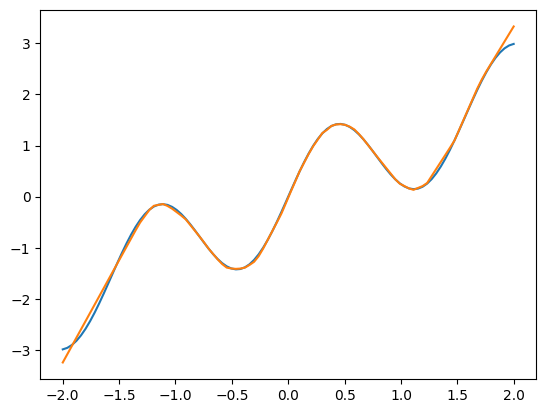

In [19]:
# print predicted values for each of the 100 x values between -2 and 2
# converting to tensor to run it through the model
# then converting it to numpy to plot it 
predictions = [MODEL(torch.tensor(sample).float()) for sample in xvalues.reshape((N,1))]
plt.plot(xvalues, xvalues + np.sin(4*xvalues))
plt.plot(xvalues, np.array([_.detach().numpy() for _ in predictions]));

In [20]:
# functions for to create above performance curve
def make_predictions(X: torch.Tensor, 
                     model: torch.nn.Module) -> List[torch.Tensor]:
    return [model(torch.tensor(sample).float()) 
            for sample in X.reshape((N,1))]

def plot_predictions_versus_ground(X: torch.Tensor, 
                                   y: torch.Tensor, 
                                   y_hat: torch.Tensor,
                                   plot_title: str="line fit") -> None:
    # assumes x and y are both numpy arrays
    # assumes y_hat is generated by make_predictions()
    plt.plot(X, y)
    plt.plot(X, np.array([_.detach().numpy() for _ in y_hat]));
    plt.title(plot_title)

MSE: 0.01
RMSE: 0.08


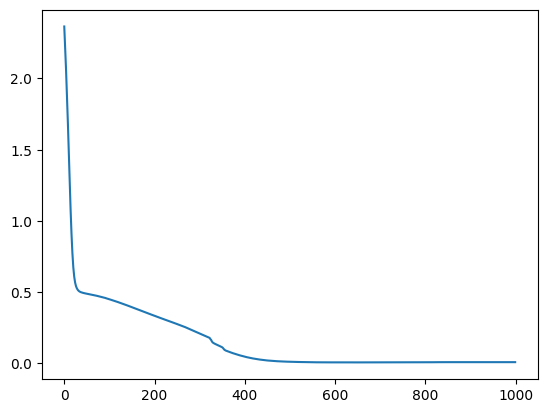

In [21]:
# visualize the mean squared error (mse)
# non-noisy sine wave
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(loss_history)
plt.show()

# Train (noisy data)

In [18]:
reset_env()

In [21]:
%%time
nprediction_history, nloss_history, nbest_mse, nbest_weights = train_regression_model(MODEL, 
                                                                                      OPT,
                                                                                      noisy_X_train, 
                                                                                      noisy_y_train, 
                                                                                      noisy_X_test, 
                                                                                      noisy_y_test, 
                                                                                      n_epochs=1000, 
                                                                                      batch_size=1, 
                                                                                      show_progress=False)

CPU times: user 35.5 s, sys: 35.8 ms, total: 35.6 s
Wall time: 35.6 s


MSE: 0.06
RMSE: 0.25


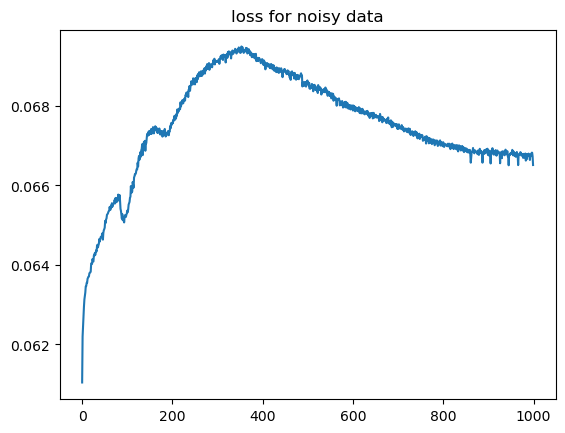

In [22]:
# noisy sine wave
print("MSE: %.2f" % nbest_mse)
print("RMSE: %.2f" % np.sqrt(nbest_mse))
plt.title("loss for noisy data")
plt.plot(nloss_history)
plt.show()

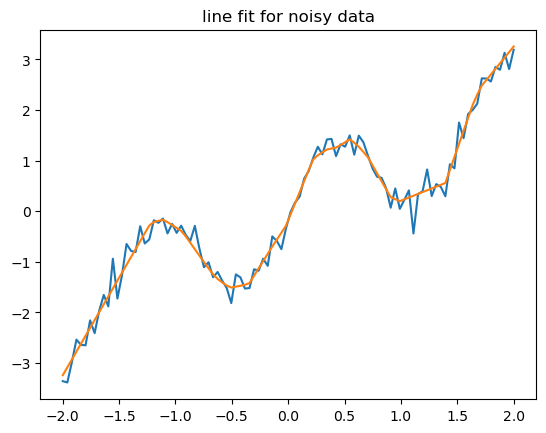

In [25]:
predictions = make_predictions(xvalues, MODEL)
plot_predictions_versus_ground(xvalues, noisy_sine_wave, predictions, plot_title="line fit for noisy data")

# Reinforcement Meta-Learning

3 classes
- layer pool
- target network -- composed of layers from layer pool
- meta learner -- decides which layers from layer pool to add to target network

So, (meta learner) -> (layer pool) -> (target network)

In [22]:
print_env()

POOL_NUM_LAYERS  1000
NETWORK_DEPTH  5
NETWORK_NUM_NODES  32
SEED  123
LOSS_FN  MSELoss()
EPOCHS  1000
MODEL  Sequential(
  (0): Linear(in_features=1, out_features=24, bias=True)
  (1): ReLU()
  (2): Linear(in_features=24, out_features=24, bias=True)
  (3): ReLU()
  (4): Linear(in_features=24, out_features=24, bias=True)
  (5): ReLU()
  (6): Linear(in_features=24, out_features=1, bias=True)
)
OPT  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
TIMESTEPS  20000
DEVICE  cpu


In [91]:
class Layer:
    '''Metadata object to hold layer and track some useful information about the layer.
    '''
    def __init__(self, 
                 layer: torch.nn.Linear):
        self.layer = layer
        self.used = False
        self.times_used = 0

class LayerPool:
    '''Pool of dense layers, each with a specified number of nodes to be composed by the RL agent.
    '''
    def __init__(self, 
                 size: int, 
                 input_dim: int,
                 output_dim: int,
                 num_nodes_per_layer: int=5):
        self.size = size
        self.num_nodes_per_layer = num_nodes_per_layer

        # these layers comprise the layer pool
        # each layer has a metadata object associated with it that stores useful information
        # each layer that is used gets updated (i.e., their parameters change and the copy in 
        # this layer pool is updated)
        # the one exception to this update rule is the first and last layers in the network,
        # or 'initial' and 'final', below
        self.layers = { 
                       id : Layer(layer) 
                       for id, layer in enumerate([torch.nn.Linear(in_features=num_nodes_per_layer, out_features=num_nodes_per_layer) for _ in range(size)])
                       }
        [torch.nn.init.xavier_uniform_(layer_meta_obj.layer.weight) for layer_meta_obj in self.layers.values()]

        # these 'initial' and 'final' layers are the first layers in each target network
        # they are also uniquely updated for each target network (i.e., they aren't included in the self.layers pool
        # for other future target networks to have access to)
        # we don't have meta objects for these layers because they are used by every target network
        self.initial_layer = torch.nn.Linear(input_dim, self.num_nodes_per_layer)
        self.final_layer = torch.nn.Linear(self.num_nodes_per_layer, output_dim)
        torch.nn.init.xavier_uniform_(self.final_layer.weight)
        torch.nn.init.xavier_uniform_(self.initial_layer.weight)



In [41]:
class TargetNetwork(gym.Env, Module):
    # TODO
    # [] consider adding +1 to self.action_space for the action that is to NOT compose another layer
    # [] ensure that rml can't choose the initial or final layer (i.e., these are not part of action space)
    def __init__(self, 
                 X: np.ndarray,
                 y: np.ndarray,
                 layer_pool: LayerPool,
                 depth: int=5,
                 num_nodes: int=32):
        super(TargetNetwork, self).__init__()
        self.observation_space = Box(low=float('-inf'), high=float('inf'), shape=(num_nodes,)) # vector with latent space of network
        self.action_space = Box(low=0., high=1., shape=(depth,)) # vector of probabilities for each layer in pool

        # data 
        self.X = X
        self.y = y
        self.curr_i = 0
        self.curr_x = torch.Tensor( [X[0]] ) # these parameterize the parameterized state (i.e., layer has parameters, and x passed through has value/parameter)
        self.curr_y = torch.Tensor( [y[0]] ) # these parameterize the parameterized state (i.e., layer has parameters, and x passed through has value/parameter)
        self.layer_pool = layer_pool

        # nn module
        # https://discuss.pytorch.org/t/how-to-add-a-layer-to-an-existing-neural-network/30129/3
        self.depth = depth
        self.fcs = torch.nn.ModuleList([self.layer_pool.initial_layer, self.layer_pool.final_layer]) # every target network begins with the same initial and final layers
        self.state = self.reset() 
        self.layerpool_indices = [] # doesn't include the indices of 'initial' and 'final' layers because they don't exist
        self.loss_fn = torch.nn.MSELoss()
        self.opt = torch.optim.Adam(self.fcs.parameters(), lr=0.001)

    def run_inner_loop(self) -> Tuple[np.ndarray, float]: 
        '''
        Performs inference using "inner loop" network that we are composing. Returns next state and its reward.

        NOTE Design choice whether to train with new layer first. Currently training first.
        '''
        self.train()
        self.curr_i  = (self.curr_i + 1) % len(self.X) # go through data multiple times / dataset does not dictate truncation condition
        self.curr_x = torch.Tensor( [self.X[self.curr_i]] ) 
        self.curr_y = torch.Tensor( [self.y[self.curr_i]] )

        def predict(x):
            for i in range(len(self.fcs) - 1): # -1 because we don't want the last output layer yet
                x = torch.nn.functional.relu(self.fcs[i](x))
            s_prime = x
            y_hat = self.fcs[-1](x)
        
            return self.loss_fn(self.curr_y, y_hat), s_prime, self.loss_fn(self.curr_y, y_hat)

        # update params
        loss, s_prime, reward = predict(self.curr_x)
        self.opt = torch.optim.Adam(self.fcs.parameters(), lr=0.001) # re-create because parameters added
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()

        # push updated params to pool (NOTE  handled by the rml class going forward.)
        for i in range(len(self.layerpool_indices)):
            pool_index = self.layerpool_indices[i]
            updated_layer_copy = self.fcs[i+1]
            self.layer_pool.layers[pool_index].layer = updated_layer_copy
            self.layer_pool.layers[pool_index].used = True
            self.layer_pool.layers[pool_index].times_used += 1
        
        # return updated state and reward
        _, s_prime, reward = predict(self.curr_x)

        return s_prime.detach().numpy().T.squeeze(), float(reward.detach().numpy())

    def reset(self) -> np.ndarray:
        # BUG  Stabebaselines3 seems to call the reset() method even when we're not terminating.
        # self.fcs = torch.nn.ModuleList([self.layer_pool.initial_layer, self.layer_pool.final_layer])

        initial_x = torch.Tensor( [self.X[0]] )
        initial_state = torch.nn.functional.relu(self.fcs[0](initial_x))

        return initial_state.detach().numpy().T.squeeze() # TODO(ms): is there a better way to massage this data?
    
    def step(self, action: np.ndarray) -> Tuple[torch.Tensor, int, bool, dict]: # "given some new layer"
        # action is probability for each layer in pool
        if len(self.fcs) < self.depth:
            pool_index = np.argmax(action)
            self.layerpool_indices.append(pool_index) # now I know what layer in pool I am composing

            # compose layer to model and get s' and r from the model
            next_layer = self.layer_pool.layers[pool_index].layer

            final_layer = self.fcs.pop(-1)
            self.fcs.append(next_layer)  # compose new layer 
            self.fcs.append(final_layer) # re-insert final layer
        s_prime, reward = self.run_inner_loop()

        # temporary terminate logic
        done = False # TODO(ms): update to make episodic? is this continuous learning?

        return (
            s_prime,
            reward, 
            done, 
            {}
        )
    
    def render(self, mode='human', close=False):
        print(f'[INFO] # of layers {len(self.fcs)}')

    def close(self):
        pass

In [42]:
class Rlmetalearn:
    '''
    Meta-policy. The parameters are learned by training on multiple different tasks, where
    each task is represented by a different dataset (X,y) and is an instance of the 
    TargetNetwork class.

    Uses multiple environmental variables, whose default values are specified with print_env().

    Example usage.
        $ pool = LayerPool(in_features, out_features)  # this assumes the same architecture for every layer in the pool
        $ tasks = ...
        $ rml = ReinforcementMetaLearning(pool, tasks)  # "you have this pool of layers, now learn these tasks"
        $ rml.train()
        $ rml.introspect(X, y) # TODO(ms): decide what this will do, then how.

    https://stable-baselines3.readthedocs.io/en/master/modules/a2c.html#example

    '''
    def __init__(self,
                layer_pool,
                tasks,
                timesteps=5000,
                device='cpu',
                overwrite=True, 
                intra_update=True,
                network_depth_limit=5,
                network_num_nodes=32):
        self.layer_pool = layer_pool
        self.tasks = tasks
        self.out_features = np.array(self.tasks[list(self.tasks.keys())[0]][1]).shape # output shape; assumes uniformity across tasks
        self.timesteps = timesteps
        self.device = device
        self.overwrite = overwrite  # TODO(ms): to implement this, need some filter on the actions returned
        self.intra_update = intra_update
        self.network_depth_limit = network_depth_limit
        self.network_num_nodes = network_num_nodes

    def train(self):
        # train on all tasks
        task_to_yhats = {}
        task_to_fcs = {}
        for i, (n, (x, y)) in enumerate(self.tasks.items()):
            print(f'[INFO] Training {i+1}/{len(self.tasks)}...')
            env = TargetNetwork(x, 
                                y, 
                                self.layer_pool,
                                self.network_depth_limit,
                                self.network_num_nodes)
            if i==0: # create new rl agent
                model  = A2C('MlpPolicy', env)
            else:    # just update the env
                model.set_env(env)

            # use stablebaselines3 api to learn
            model.learn(total_timesteps=self.timesteps)          

            # predict and store
            y_hats = predict_from_composed_layers(env.fcs)
            task_to_yhats[n] = y_hats
            task_to_fcs[n] = env.fcs

            # update
            self.update_params(env.layerpool_indices, env.fcs)

        self.task_to_yhats = task_to_yhats
        self.task_to_fcs = task_to_fcs
        

    def update_params(self, pool_indices, layers):
        # push updated params to pool
        # NOTE  number of layerpool_indices and layers should be 1:1
        for i in range(len(pool_indices)):
            pool_index = pool_indices[i]
            updated_layer_copy = layers[i+1]
            self.layer_pool.layers[pool_index].layer = updated_layer_copy
            self.layer_pool.layers[pool_index].used = True
            self.layer_pool.layers[pool_index].times_used += 1

In [ ]:
# INITIAL IMPLEMENTATION
#   'overwrite=True'                                  ...not clear if overwriting is helpful or not
#   'pool_size=(network_depth_limit*num_tasks)         ...to make the calculate less arbitrary and tie it something
#   'network_depth_limit=5'                            ...limit each composed network to 5 layers
#   'intra_update=True'                               ...whether to update weights while composing the networks

## Experiment: getting the stablebaselines environment to work

In [154]:
print_env()

NUM_POOL_LAYERS  1000
MAX_TARGET_LAYERS  10
NUM_NODES  32
SEED  123
LOSS_FN  MSELoss()
EPOCHS  1000
MODEL  Sequential(
  (0): Linear(in_features=1, out_features=24, bias=True)
  (1): ReLU()
  (2): Linear(in_features=24, out_features=24, bias=True)
  (3): ReLU()
  (4): Linear(in_features=24, out_features=24, bias=True)
  (5): ReLU()
  (6): Linear(in_features=24, out_features=1, bias=True)
)
OPT  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
TIMESTEPS  5000
DEVICE  cpu


In [155]:
TIMESTEPS=30000

In [156]:
%%time
X = xvalues     # (100,1) <- np.linscape(-2, 2, 100)
y = sine_wave   # (100,) <- [np.sin(x) for x in X]
in_features = 1
out_features = 1

layer_pool = LayerPool(in_features, out_features, num_layers=NUM_POOL_LAYERS)
env = TargetNetwork(X, y, layer_pool)

metarl = A2C('MlpPolicy', env)
metarl.learn(total_timesteps=TIMESTEPS)          

CPU times: total: 12min 43s
Wall time: 1min 50s


In [157]:
# performance
y_hats = []
for x in np.linspace(-2,2,100):
    x = torch.Tensor([x])
    for i in range(len(env.fcs)-1):
        x = torch.nn.functional.relu(env.fcs[i](x))
    x = env.fcs[-1](x) # do not relu the very last calculation
    y_hats.append(x)
print(y_hats)

[tensor([-2.8678], grad_fn=<AddBackward0>), tensor([-2.8322], grad_fn=<AddBackward0>), tensor([-2.7650], grad_fn=<AddBackward0>), tensor([-2.6612], grad_fn=<AddBackward0>), tensor([-2.5559], grad_fn=<AddBackward0>), tensor([-2.4417], grad_fn=<AddBackward0>), tensor([-2.3057], grad_fn=<AddBackward0>), tensor([-2.1484], grad_fn=<AddBackward0>), tensor([-1.9878], grad_fn=<AddBackward0>), tensor([-1.8094], grad_fn=<AddBackward0>), tensor([-1.6385], grad_fn=<AddBackward0>), tensor([-1.4711], grad_fn=<AddBackward0>), tensor([-1.3033], grad_fn=<AddBackward0>), tensor([-1.1315], grad_fn=<AddBackward0>), tensor([-0.9629], grad_fn=<AddBackward0>), tensor([-0.7817], grad_fn=<AddBackward0>), tensor([-0.6160], grad_fn=<AddBackward0>), tensor([-0.4713], grad_fn=<AddBackward0>), tensor([-0.3502], grad_fn=<AddBackward0>), tensor([-0.2273], grad_fn=<AddBackward0>), tensor([-0.1897], grad_fn=<AddBackward0>), tensor([-0.2329], grad_fn=<AddBackward0>), tensor([-0.3278], grad_fn=<AddBackward0>), tensor([-0

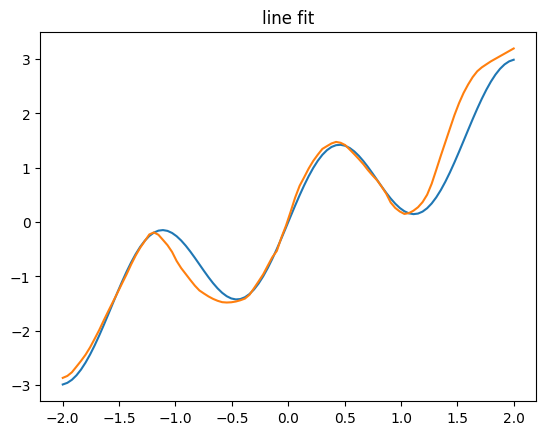

In [158]:
plot_predictions_versus_ground(np.linspace(-2,2,100), sine_wave, y_hats)

## Experiment: increasing # of layers

More layers don't help (this simple example). They do hurt performance somewhat, but after a certain depth, it becomes random and a network with thousands more layers can perform better than a network with thousands more layers less.

In [159]:
def predict_from_composed_layers(layers):
    y_hats = []
    for x in np.linspace(-2,2,100):
        x = torch.Tensor([x])
        for i in range(len(layers)-1):
            x = torch.nn.functional.relu(layers[i](x))
        x = layers[-1](x) # do not relu the very last calculation
        y_hats.append(x)
    return y_hats

### 5 -> 50 depth networks (5 step size)

In [57]:
%%time
X = xvalues # (100,1) <- np.linscape(-2, 2, 100)
y = sine_wave   # (100,) <- [np.sin(x) for x in X]
in_features = 1
out_features = 1

depth_to_yhats = {}
for num_layers in np.arange(5, 50, 5):
    reset_env(NUM_LAYERS=num_layers)
    layer_pool = LayerPool(in_features, out_features, num_layers=NUM_POOL_LAYERS)
    env = TargetNetwork(
        X, 
        y, 
        layer_pool, 
        max_target_layers=MAX_TARGET_LAYERS,
        num_nodes_per_layer=NUM_NODES,
        )
    metarl = A2C('MlpPolicy', env)
    metarl.learn(total_timesteps=TIMESTEPS)          
    y_hats = predict_from_composed_layers(env.fcs)
    print(f'depth {num_layers}:  {y_hats}')
    depth_to_yhats[num_layers] = y_hats

depth 5:  [tensor([-2.6857], grad_fn=<AddBackward0>), tensor([-2.6110], grad_fn=<AddBackward0>), tensor([-2.5245], grad_fn=<AddBackward0>), tensor([-2.4118], grad_fn=<AddBackward0>), tensor([-2.2911], grad_fn=<AddBackward0>), tensor([-2.1597], grad_fn=<AddBackward0>), tensor([-2.0256], grad_fn=<AddBackward0>), tensor([-1.8915], grad_fn=<AddBackward0>), tensor([-1.7573], grad_fn=<AddBackward0>), tensor([-1.6232], grad_fn=<AddBackward0>), tensor([-1.4891], grad_fn=<AddBackward0>), tensor([-1.3549], grad_fn=<AddBackward0>), tensor([-1.2325], grad_fn=<AddBackward0>), tensor([-1.1305], grad_fn=<AddBackward0>), tensor([-1.0286], grad_fn=<AddBackward0>), tensor([-0.9266], grad_fn=<AddBackward0>), tensor([-0.8247], grad_fn=<AddBackward0>), tensor([-0.7227], grad_fn=<AddBackward0>), tensor([-0.6208], grad_fn=<AddBackward0>), tensor([-0.5225], grad_fn=<AddBackward0>), tensor([-0.4332], grad_fn=<AddBackward0>), tensor([-0.3488], grad_fn=<AddBackward0>), tensor([-0.2825], grad_fn=<AddBackward0>), 

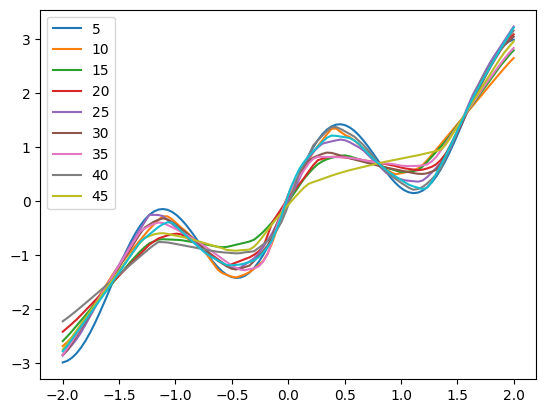

In [63]:
plt.plot(X, y)
for y_hats in depth_to_yhats.values():
    plt.plot(X, [y_hat.detach().numpy() for y_hat in y_hats])
plt.legend([str(depth) for depth in depth_to_yhats.keys()]);

In [64]:
%%time
X = xvalues # (100,1) <- np.linscape(-2, 2, 100)
y = sine_wave   # (100,) <- [np.sin(x) for x in X]
in_features = 1
out_features = 1

depth_to_yhats = {}
for num_layers in np.arange(10, 100, 10):
    reset_env(NUM_LAYERS=num_layers)
    layer_pool = LayerPool(in_features, out_features, num_layers=NUM_POOL_LAYERS)
    env = TargetNetwork(
        X, 
        y, 
        layer_pool, 
        max_target_layers=MAX_TARGET_LAYERS,
        num_nodes_per_layer=NUM_NODES,
        )
    metarl = A2C('MlpPolicy', env)
    metarl.learn(total_timesteps=TIMESTEPS)          
    y_hats = predict_from_composed_layers(env.fcs)
    print(f'depth {num_layers}:  {y_hats}')
    depth_to_yhats[num_layers] = y_hats

depth 10:  [tensor([-2.9578], grad_fn=<AddBackward0>), tensor([-2.8413], grad_fn=<AddBackward0>), tensor([-2.7201], grad_fn=<AddBackward0>), tensor([-2.5898], grad_fn=<AddBackward0>), tensor([-2.4468], grad_fn=<AddBackward0>), tensor([-2.2985], grad_fn=<AddBackward0>), tensor([-2.1501], grad_fn=<AddBackward0>), tensor([-2.0018], grad_fn=<AddBackward0>), tensor([-1.8535], grad_fn=<AddBackward0>), tensor([-1.7052], grad_fn=<AddBackward0>), tensor([-1.5538], grad_fn=<AddBackward0>), tensor([-1.3997], grad_fn=<AddBackward0>), tensor([-1.2456], grad_fn=<AddBackward0>), tensor([-1.1174], grad_fn=<AddBackward0>), tensor([-1.0031], grad_fn=<AddBackward0>), tensor([-0.8888], grad_fn=<AddBackward0>), tensor([-0.7745], grad_fn=<AddBackward0>), tensor([-0.6663], grad_fn=<AddBackward0>), tensor([-0.5694], grad_fn=<AddBackward0>), tensor([-0.4955], grad_fn=<AddBackward0>), tensor([-0.4298], grad_fn=<AddBackward0>), tensor([-0.4184], grad_fn=<AddBackward0>), tensor([-0.4353], grad_fn=<AddBackward0>),

### 10 -> 100 depth networks (10 step size)

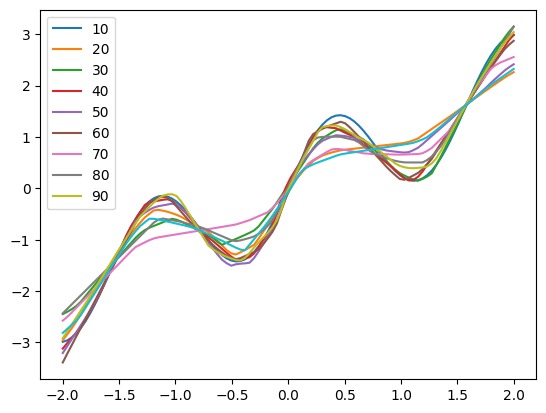

In [66]:
plt.plot(X, y)
for y_hats in depth_to_yhats.values():
    plt.plot(X, [y_hat.detach().numpy() for y_hat in y_hats])
plt.legend([str(depth) for depth in depth_to_yhats.keys()]);

### 10 -> 1010 depth networks (1000 step size)

In [67]:
%%time
X = xvalues # (100,1) <- np.linscape(-2, 2, 100)
y = sine_wave   # (100,) <- [np.sin(x) for x in X]
in_features = 1
out_features = 1

depth_to_yhats = {}
for num_layers in np.arange(10, 10010, 1000):
    reset_env(NUM_LAYERS=num_layers)
    layer_pool = LayerPool(in_features, out_features, num_layers=NUM_POOL_LAYERS)
    env = TargetNetwork(
        X, 
        y, 
        layer_pool, 
        max_target_layers=MAX_TARGET_LAYERS,
        num_nodes_per_layer=NUM_NODES,
        )
    metarl = A2C('MlpPolicy', env)
    metarl.learn(total_timesteps=TIMESTEPS)          
    y_hats = predict_from_composed_layers(env.fcs)
    print(f'depth {num_layers}:  {y_hats}')
    depth_to_yhats[num_layers] = y_hats

depth 10:  [tensor([-2.6770], grad_fn=<AddBackward0>), tensor([-2.5701], grad_fn=<AddBackward0>), tensor([-2.4563], grad_fn=<AddBackward0>), tensor([-2.3424], grad_fn=<AddBackward0>), tensor([-2.2285], grad_fn=<AddBackward0>), tensor([-2.1142], grad_fn=<AddBackward0>), tensor([-1.9919], grad_fn=<AddBackward0>), tensor([-1.8697], grad_fn=<AddBackward0>), tensor([-1.7474], grad_fn=<AddBackward0>), tensor([-1.6242], grad_fn=<AddBackward0>), tensor([-1.5009], grad_fn=<AddBackward0>), tensor([-1.3776], grad_fn=<AddBackward0>), tensor([-1.2544], grad_fn=<AddBackward0>), tensor([-1.1311], grad_fn=<AddBackward0>), tensor([-1.0078], grad_fn=<AddBackward0>), tensor([-0.8845], grad_fn=<AddBackward0>), tensor([-0.7615], grad_fn=<AddBackward0>), tensor([-0.6402], grad_fn=<AddBackward0>), tensor([-0.5265], grad_fn=<AddBackward0>), tensor([-0.4165], grad_fn=<AddBackward0>), tensor([-0.3581], grad_fn=<AddBackward0>), tensor([-0.3035], grad_fn=<AddBackward0>), tensor([-0.2515], grad_fn=<AddBackward0>),

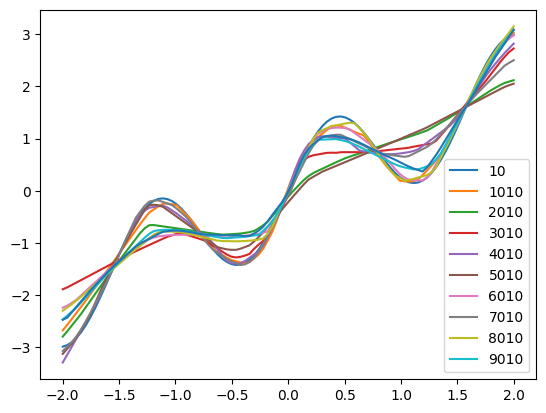

In [68]:
plt.plot(X, y)
for y_hats in depth_to_yhats.values():
    plt.plot(X, [y_hat.detach().numpy() for y_hat in y_hats])
plt.legend([str(depth) for depth in depth_to_yhats.keys()]);

## Experiment: learning from multiple tasks (8)

- 8 tasks are 8 slightly different sine curves to create models for 
- only varying amplitude of sine curve
- same layer pool for all 8 runs
- same outer-loop (metarl) for all 8 runs
- different inner-loop (target network) for all 8 runs
- transfer analysis
    - do pre-trained layers get used?
        - LR or layer reuse
    - to what degree are any pre-trained layers useful?
        - APS or average perturbation analysis

In [125]:
NUM_TASKS=8
tasks = {str(round(f))+str("_task") : (xvalues, (xvalues/round(f) + np.sin(4*xvalues) + np.random.normal(0, 0.2, 100))) for f in np.linspace(1, 1000, NUM_TASKS)}
print(tasks.keys())

dict_keys(['1_task', '144_task', '286_task', '429_task', '572_task', '715_task', '857_task', '1000_task'])


In [126]:
TIMESTEPS=5000

In [106]:
MAX_TARGET_LAYERS=20

In [70]:
%%time
X = xvalues # (100,1) <- np.linspace(-2, 2, 100)
y = sine_wave   # (100,) <- [np.sin(x) for x in X]
in_features = 1
out_features = 1
layer_pool = LayerPool(in_features, out_features, num_layers=NUM_POOL_LAYERS)

# train on 8 tasks
task_to_yhats = {}
task_to_fcs = {}
for i, (n, curve) in enumerate(tasks.items()):
    print(f'[INFO] Training {i+1}/{NUM_TASKS}.')
    env = TargetNetwork(
        X, 
        curve, 
        layer_pool, 
        max_target_layers=MAX_TARGET_LAYERS,
        num_nodes_per_layer=NUM_NODES,
        )
    if i==0: # create new rl agent
        metarl = A2C('MlpPolicy', env)
    else:    # just update the env
        metarl.set_env(env)
        print(f'[INFO] Updated environment to {env.y}')

    print(env.fcs)
    metarl.learn(total_timesteps=TIMESTEPS)          
    y_hats = predict_from_composed_layers(env.fcs)
    task_to_yhats[n] = y_hats
    task_to_fcs[n] = env.fcs

[INFO] Training 1/8.
[INFO] Reset env.
[INFO] Initial state calculated.
ModuleList(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): Linear(in_features=32, out_features=1, bias=True)
)
[INFO] Reset env.
[INFO] Initial state calculated.
[INFO] Training 2/8.
[INFO] Reset env.
[INFO] Initial state calculated.
[INFO] Updated environment to [-0.64931858 -0.78289399 -1.04747229 -0.8678806  -1.04122755 -0.61480868
 -0.76506926 -0.25689616 -0.74800869  0.02522739 -0.20884307  0.101326
  0.11983829  0.59619466  0.31036601  0.16333929  0.82685634  0.99193342
  0.89374756  1.10827718  0.95335537  1.04992676  1.14662011  0.80950132
  0.91124284  0.99892075  0.73532671  0.49691488  0.68793388 -0.0380456
  0.06387115 -0.24806436 -0.84960281 -0.58515691 -0.69264263 -0.38716936
 -1.18731513 -1.39730708 -1.00601598 -0.76310495 -0.95007763 -1.18519574
 -0.59104001 -0.90206177 -0.80121778 -0.74115205 -0.6270313  -0.55882828
 -0.40801598 -0.17374587  0.25171479  0.18867219  0.50990368  0.78

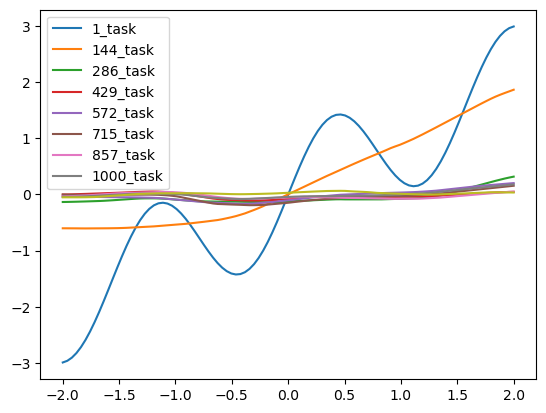

In [ ]:
%%time
'''
Decreasing max layers helps. At 1000 (rather than 5), the lines are flat. Nothing is learned.
Increasing timesteps helps. More steps.
'''
TIMESTEPS=1000
MAX_TARGET_LAYERS=5

X = xvalues # (100,1) <- np.linscape(-2, 2, 100)
y = sine_wave   # (100,) <- [np.sin(x) for x in X]
in_features = 1
out_features = 1
layer_pool = LayerPool(in_features, out_features, num_layers=NUM_POOL_LAYERS)

# train on 8 tasks
task_to_yhats = {}
for i, (n, curve) in enumerate(tasks.items()):
    print(f'[INFO] Training {i+1}/{NUM_TASKS}.')
    env = TargetNetwork(
        X, 
        curve, 
        layer_pool, 
        max_target_layers=MAX_TARGET_LAYERS,
        num_nodes_per_layer=NUM_NODES,
        )
    if i==0: # create new rl agent
        metarl = A2C('MlpPolicy', env)
    else:    # just update the env
        metarl.set_env(env)
        print(f'[INFO] Updated environment to {env.y}')

    metarl.learn(total_timesteps=TIMESTEPS)          
    y_hats = predict_from_composed_layers(env.fcs)
    task_to_yhats[n] = y_hats

# performance
plt.plot(X, y)
for y_hats in task_to_yhats.values():
    plt.plot(X, [y_hat.detach().numpy() for y_hat in y_hats])
plt.legend([str(depth) for depth in task_to_yhats.keys()]);

In [ ]:
TIMESTEPS=30000
MAX_TARGET_LAYERS=5
layer_pool = LayerPool(in_features, out_features, num_layers=NUM_POOL_LAYERS)
task_to_yhats = {}
for i, (n, curve) in enumerate(tasks.items()):
    print(f'[INFO] Training {i+1}/{NUM_TASKS}.')
    env = TargetNetwork(
        X, 
        curve, 
        layer_pool, 
        max_target_layers=MAX_TARGET_LAYERS,
        num_nodes_per_layer=NUM_NODES,
        )
    if i==0: # create new rl agent
        metarl = A2C('MlpPolicy', env)
    else:    # just update the env
        metarl.set_env(env)
        print(f'[INFO] Updated environment to {env.y}')

    metarl.learn(total_timesteps=TIMESTEPS)          
    y_hats = predict_from_composed_layers(env.fcs)
    task_to_yhats[n] = y_hats

[INFO] Training 1/8.
[INFO] Training 2/8.
[INFO] Updated environment to [-0.82362782 -1.08704724 -0.96305202 -1.18899946 -0.91734876 -0.76668388
 -0.43577197 -0.60412609 -0.50579267 -0.30293724 -0.11176766  0.16759404
  0.43085266  0.46108166  0.41111722  0.73103953  0.59737246  0.96043411
  0.8375236   0.82933388  0.97825867  0.73650278  0.95588938  0.51349601
  0.82635639  0.70333004  0.464231    0.44769892  0.46615842 -0.25714709
 -0.08921493 -0.16247944 -0.2700227  -0.29320805 -0.70752293 -1.17091789
 -1.0201006  -1.31385189 -0.93812108 -1.15047056 -1.15726049 -1.18249065
 -0.76322589 -1.06426827 -0.75503417 -0.81147257 -0.57918091 -0.64867848
 -0.28172316  0.2165158  -0.10536994 -0.05849649  0.3177476   0.62313214
  0.86600087  0.9315234   0.79681896  0.72168653  1.58736253  1.04000382
  1.09984033  0.68318393  0.79673796  0.60285719  0.56836718  0.4776959
  0.61036434  0.33731578  0.23806247  0.01709905 -0.59422207  0.09638116
 -0.72900261 -0.5614937  -1.02373323 -0.91326821 -0.8

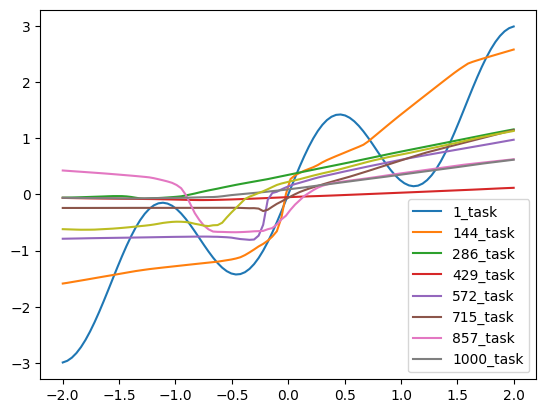

In [73]:
# increased timesteps from 10000 to 30000
plt.plot(X, y)
for y_hats in task_to_yhats.values():
    plt.plot(X, [y_hat.detach().numpy() for y_hat in y_hats])
plt.legend([str(depth) for depth in task_to_yhats.keys()]);

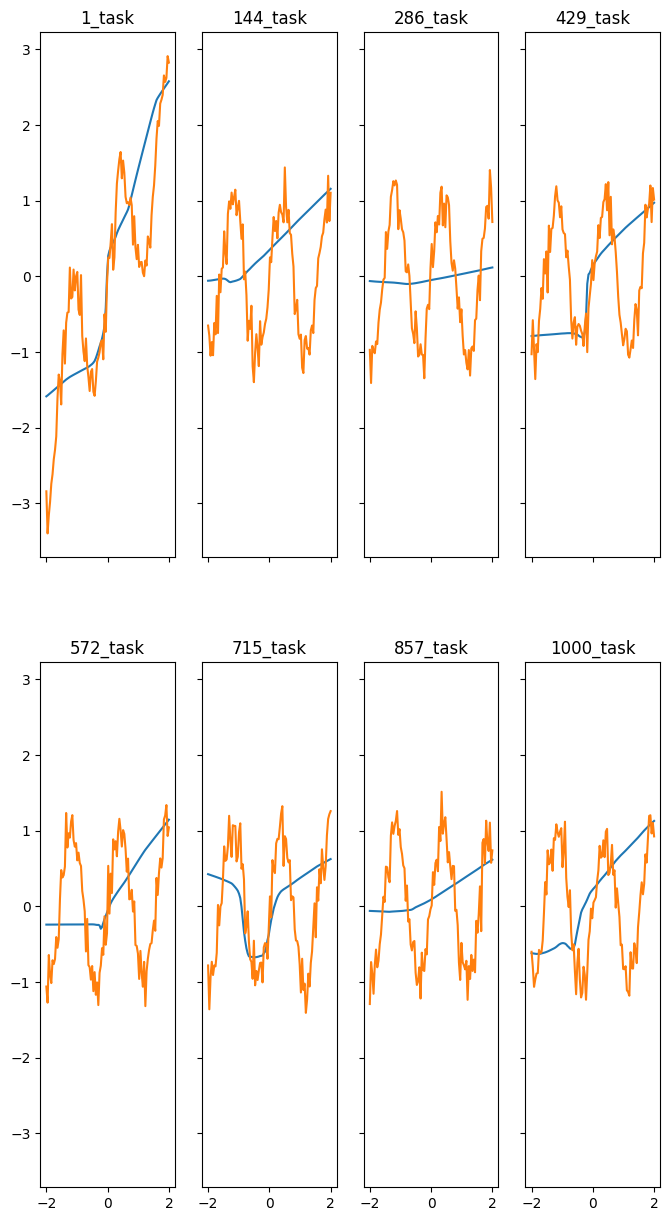

In [74]:
rows = 2
cols = 4
fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(8,15))
k = 0
for i in range(rows):
    for j in range(cols):
        task = list(task_to_yhats.keys())[k]
        y_hats = task_to_yhats[task]
        axs[i, j].plot(X, [y_hat.detach().numpy() for y_hat in y_hats])
        axs[i, j].plot(X, list(tasks.items())[k][1])
        axs[i,j].set_title(task)
        k+=1

### RML class

In [160]:
print_env()

NUM_POOL_LAYERS  1000
MAX_TARGET_LAYERS  10
NUM_NODES  32
SEED  123
LOSS_FN  MSELoss()
EPOCHS  1000
MODEL  Sequential(
  (0): Linear(in_features=1, out_features=24, bias=True)
  (1): ReLU()
  (2): Linear(in_features=24, out_features=24, bias=True)
  (3): ReLU()
  (4): Linear(in_features=24, out_features=24, bias=True)
  (5): ReLU()
  (6): Linear(in_features=24, out_features=1, bias=True)
)
OPT  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
TIMESTEPS  30000
DEVICE  cpu


In [2]:
TIMESTEPS=5000
NUM_TASKS=20
NETWORK_DEPTH=5

In [3]:
# rml requires
# (1) uniform dimension linear layers for regression
# (2) some supervised learning regression task
pool = LayerPool(in_features, out_features, num_layers=(NUM_TASKS*NETWORK_DEPTH))
tasks = {
    str(round(f))+str("_task") : (xvalues, 
                                  (A*np.sin(f*xvalues) + np.random.normal(0, 0.2, 100))) 
                                  for A, f in zip(np.linspace(1, NUM_TASKS, NUM_TASKS, np.linspace(1, NUM_TASKS, NUM_TASKS)))
    }
rml = Rlmetalearn(pool, tasks)

NameError: name 'LayerPool' is not defined

In [4]:
np.linspace(1, NUM_TASKS, NUM_TASKS)

NameError: name 'np' is not defined

In [166]:
rml.train()

[INFO] Training 1/8...
[INFO] Training 2/8...
[INFO] Training 3/8...
[INFO] Training 4/8...
[INFO] Training 5/8...
[INFO] Training 6/8...
[INFO] Training 7/8...
[INFO] Training 8/8...


In [167]:
# test access to training maps
print(rml.task_to_fcs)
print(rml.task_to_yhats)

{'1_task': ModuleList(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1-8): 8 x Linear(in_features=32, out_features=32, bias=True)
  (9): Linear(in_features=32, out_features=1, bias=True)
), '144_task': ModuleList(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1-8): 8 x Linear(in_features=32, out_features=32, bias=True)
  (9): Linear(in_features=32, out_features=1, bias=True)
), '286_task': ModuleList(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1-8): 8 x Linear(in_features=32, out_features=32, bias=True)
  (9): Linear(in_features=32, out_features=1, bias=True)
), '429_task': ModuleList(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1-8): 8 x Linear(in_features=32, out_features=32, bias=True)
  (9): Linear(in_features=32, out_features=1, bias=True)
), '572_task': ModuleList(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1-8): 8 x Linear(in_features=32, out_features=32, bias=True)
  (9): Linear(in_features=32, out_fe

### Layer reuse analysis (LRA)

- number of times a layer is used for new tasks (which layers seem most broadly applicable)
- sum of absolute values of gradient components (which layer has the most impact on performance)

In [86]:
# create 20 tasks
amp_factors = [i for i in range(1, NUM_TASKS+1)]
freq_factors = [i for i in range(1, NUM_TASKS+1)]
tasks = {
    i : 
    (
        np.linspace(-2, 2, 100),              # X
        a*np.sin(f*np.linspace(-2, 2, 100))   # y
    ) 
    for i, (a, f) in enumerate(zip(amp_factors, freq_factors))
}
print(tasks)

{0: (array([-2.        , -1.95959596, -1.91919192, -1.87878788, -1.83838384,
       -1.7979798 , -1.75757576, -1.71717172, -1.67676768, -1.63636364,
       -1.5959596 , -1.55555556, -1.51515152, -1.47474747, -1.43434343,
       -1.39393939, -1.35353535, -1.31313131, -1.27272727, -1.23232323,
       -1.19191919, -1.15151515, -1.11111111, -1.07070707, -1.03030303,
       -0.98989899, -0.94949495, -0.90909091, -0.86868687, -0.82828283,
       -0.78787879, -0.74747475, -0.70707071, -0.66666667, -0.62626263,
       -0.58585859, -0.54545455, -0.50505051, -0.46464646, -0.42424242,
       -0.38383838, -0.34343434, -0.3030303 , -0.26262626, -0.22222222,
       -0.18181818, -0.14141414, -0.1010101 , -0.06060606, -0.02020202,
        0.02020202,  0.06060606,  0.1010101 ,  0.14141414,  0.18181818,
        0.22222222,  0.26262626,  0.3030303 ,  0.34343434,  0.38383838,
        0.42424242,  0.46464646,  0.50505051,  0.54545455,  0.58585859,
        0.62626263,  0.66666667,  0.70707071,  0.74747475, 

In [93]:
# create layer pool
size = NUM_TASKS * NETWORK_DEPTH
input_dim = 1
output_dim = 1
pool = LayerPool(size, input_dim, output_dim, NETWORK_NUM_NODES)
print(f'size  {size}')
print(f'input_dim  {input_dim}')
print(f'output_dim  {output_dim}')

size  100
input_dim  1
output_dim  1


In [95]:
# shape of (x, y) is (2, 100) because each has (100,) values
np.array(tasks[list(tasks.keys())[0]]).shape

(2, 100)

In [97]:
# create rml object
rml = Rlmetalearn(pool, tasks, TIMESTEPS)

In [ ]:
# TRAINING PHASE
# train for some number of related tasks (TODO(ms): look at how to randomize these tasks well)
# layers in layer pool get updated for each individual task
# at this point, the rlmetalearn outer-loop chooses layers to add randomly?
#   with each new task in training phase, it will be a little better
#   or actually no it won't because we can't overwrite layers after they're used
#   one variable to play with is pool size, making it smaller forces reuse
# hyperparams (TODO(ms): add to rml)
#   'num_tasks=20'                                     ...20 different sine curves, varying amplitude and frequency
#   'overwrite=False'                                  ...not clear if overwriting is helpful or not
#   'pool_size=(network_depth_limit*num_tasks)         ...to make the calculate less arbitrary and tie it something
#   'network_depth_limit=5'                            ...limit each composed network to 5 layers
#   

# TRANSFER PHASE
# hyperparams (TODO(ms): add to rml)
#   'intra_update=False'                               ...whether to update weights while composing the networks
# say the goal of the rml is to choose the best layers within this constraint of 'network_depth_limit', e.g., the best 5 layers in some order
# assume that there are 5 layers in some sequence that are better than others
# how does the rml network choose better and better layers? 
# while it is doing that, is it also training / updating the weights as it goes?
# the way we have e-greedy, what is our hyperparameter for exploration here?
#   one option is we have episodes of 'network_depth_limit' + 'timesteps' length where it first choose layers and then trains
#   so the termination condition for RL is when the 'network_depth_limit' is met
#   
#   another option is a continuous learning approach where it replaces certain layers somewhere in the network

# OTHER THOUGHTS
# Will x ever change across the tasks passed Rlmetalearn? 
# What would happen if x was different? Rather than 100 points, I had a sine curve with 50 points?
# True. From the perspective of the meta-learner, it doesn't care. It gets the latent space of the neural network it composes. True?
# But, the y shape cannot change. True?
# True, it cannot change. Unless layer pool was changed to take variable output shapes and have numerous 'final' layers to accomodate each output shape

# INITIAL IMPLEMENTATION
#   'overwrite=True'                                  ...not clear if overwriting is helpful or not
#   'pool_size=(network_depth_limit*num_tasks)         ...to make the calculate less arbitrary and tie it something
#   'network_depth_limit=5'                            ...limit each composed network to 5 layers
#   'intra_update=True'                               ...whether to update weights while composing the networks


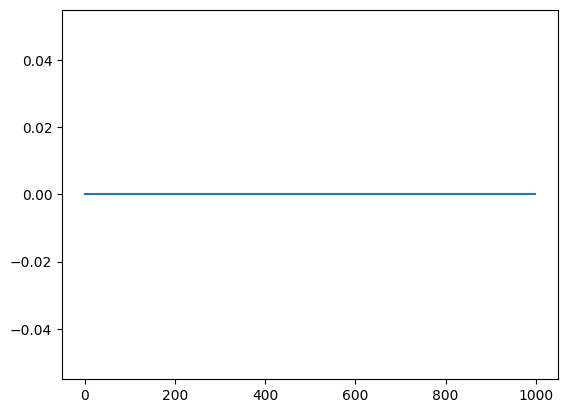

In [168]:
# histogram with x (layers 1-n) and y (# times used)
plt.plot(layer_pool.layers.keys(), [layer_obj.times_used for layer_obj in layer_pool.layers.values()]);

### Average perturbation analysis (APS)